In [ ]:
!pip install emoji

     |████████████████████████████████| 170 kB 29.2 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=a9e0027da357c9865328d8ed10a2aba5d7994ebf3843baab953d32a9558964f1
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


# Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import string, re, requests, csv
from google.colab import drive
from wordcloud import WordCloud
from gensim.corpora import WikiCorpus

In [ ]:
from nltk import word_tokenize, sent_tokenize
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load dataset

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Data/test.csv')
train.head()

,text,label,username,likes,datetime
0,🔥,negative,lanyardsemarang,0,2020-11-02
1,Naik Turun maju can5ik 😂😂😂😂,neutral,hadi_soeparno,1,2021-03-29
2,Prosentase tingkat kematian karena covid 19 ut...,neutral,heryadisaputro,0,2020-09-22
3,Rapid test/ test swab PCR Di DKK/dinkes Semara...,negative,airlangga15,0,2020-05-29
4,"Min, area pedurungan bs dilakukan dmn,",neutral,fauzanabell,0,2021-06-22


# EDA

## Wordcloud

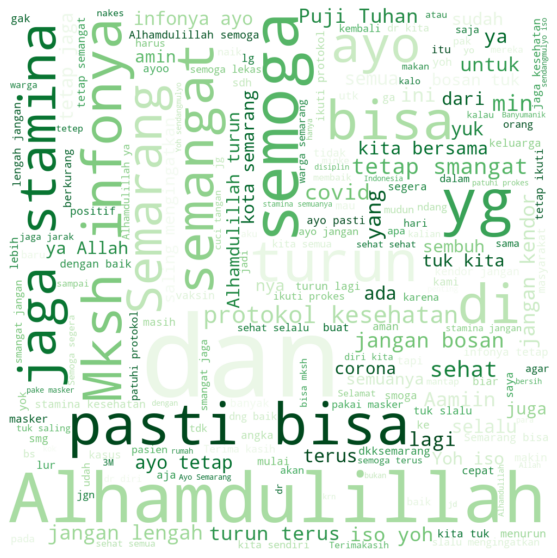

In [ ]:
# positive comments before preprocessing
data_pos = train[train['label'] == 'positive']

all_text = ' '.join(word for word in data_pos['text'])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

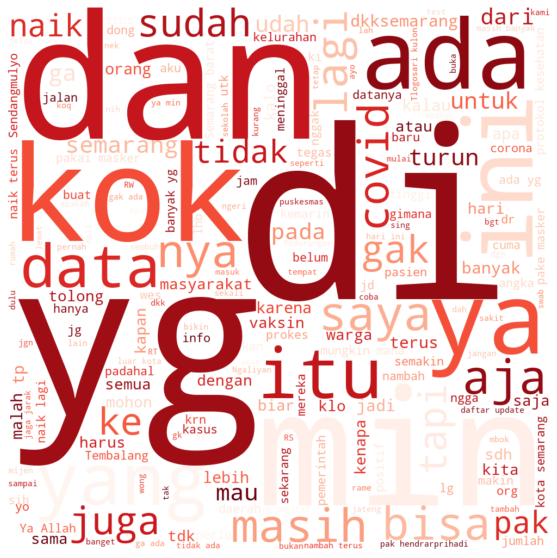

In [ ]:
# negative comments before preprocessing
data_neg = train[train['label'] == 'negative']

all_text = ' '.join(word for word in data_neg['text'])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

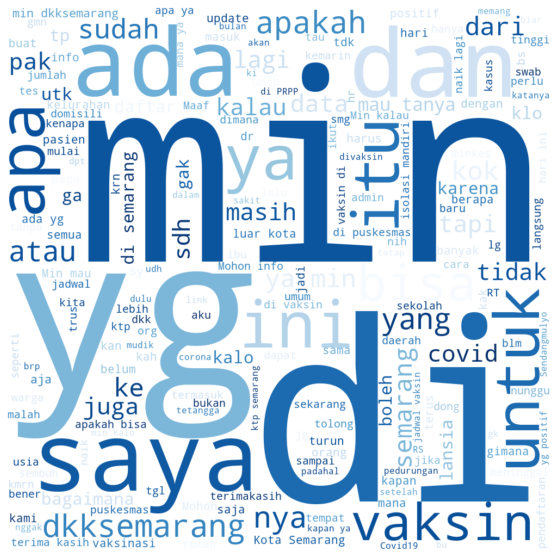

In [ ]:
# neutral comments before preprocessing
data_neut = train[train['label'] == 'neutral']

all_text = ' '.join(word for word in data_neut['text'])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [ ]:
# value counts
train['label'].value_counts()

neutral     2926
negative    2775
positive    2266
Name: label, dtype: int64

# Preprocess

In [ ]:
train_text = train['text']
test_text = test['text']

In [ ]:
# CLEANSING
def cleansing(data):

    # lowercasing
    data = data.lower()

    # remove punctuation
    punct = string.punctuation
    translator = str.maketrans(punct, ' '*len(punct))
    data = data.translate(translator)

    # remove ASCII dan unicode
    # data = data.encode('ascii', 'ignore').decode('utf-8')
    # data = re.sub(r'[^\x00-\x7f]',r'', data)
    
    # remove newline
    data = data.replace('\n', ' ')

    # remove digit
    pattern = r'[0-9]'
    data = re.sub(pattern, '', data)

    # remove extra space
    data = ' '.join(data.split())
    
    return data

import sys
# REMOVE EMOJI
# def remove_emoji(data):
#     emoji_pattern = re.compile("["
#                            u"\U0001F600-\U0001F64F"  # emoticons
#                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            u"\U00002702-\U000027B0"
#                            u"\U000024C2-\U0001F251"
#                            "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r' ', data)

# CONVERT EMOJIS
import emoji
import functools
import operator
import re

df_emoji = pd.read_csv('/content/drive/MyDrive/Data/emoji_to_text.csv')
UNICODE_EMO = {row['emoji']:row['makna'] for idx,row in df_emoji.iterrows()}
def convert_emojis(text):
    # split emojis
    em_split_emoji = emoji.get_emoji_regexp().split(text)
    em_split_whitespace = [substr.split() for substr in em_split_emoji]
    em_split = functools.reduce(operator.concat, em_split_whitespace)
    text = ' '.join(em_split)

    # convert emojis
    for emot in UNICODE_EMO:
        text = re.sub(r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()), text)
    return text.lower()

# CONSTRUCT KAMUS ALAY
text_path1 = 'https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/kbba.txt'
text_path2 = 'https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv'
kamus_alay1 = pd.read_csv(text_path1, delimiter="\t", header=None, names=['slang', 'formal'])
kamus_alay2 = pd.read_csv(text_path2)
kamus_alay = pd.concat([kamus_alay1, kamus_alay2[['slang', 'formal']]]).reset_index(drop=True)

dict_alay = dict()
for index, row in kamus_alay.iterrows():
    dict_alay[row['slang']] = row['formal']

# NORMALIZE COLLOQUIAL/ALAY
def normalize_text(data):
  word_tokens = word_tokenize(data)
  result = [dict_alay.get(w,w) for w in word_tokens]
  return ' '.join(result)


# CONSTRUCT STOPWORDS
rama_stopword = "https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/stopword.txt"
yutomo_stopword = "https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt"
fpmipa_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/fpmipa-stopwords.txt"
sastrawi_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/sastrawi-stopwords.txt"
aliakbar_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/aliakbars-bilp.txt"
pebahasa_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/pebbie-pebahasa.txt"
elang_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-id.txt"
nltk_stopword = stopwords.words('indonesian')

path_stopwords = [rama_stopword, yutomo_stopword, fpmipa_stopword, sastrawi_stopword, 
                  aliakbar_stopword, pebahasa_stopword, elang_stopword]

# CUSTOM STOPWORDS
other = '''
admin mimin min minkes kalo nya username
'''

# gabungkan stopwords
stopwords_l = nltk_stopword
for path in path_stopwords:
    response = requests.get(path)
    stopwords_l += response.text.split('\n')

st_words = set(stopwords_l)
other_stopword = set(other.split())

stop_words = st_words | other_stopword

# REMOVE STOPWORDS
def remove_stopword(text, stop_words=stop_words):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

In [ ]:
# full pipeline preprocess
def preprocess(data):
    data = cleansing(data)
    # data = remove_emoji(data)
    data = convert_emojis(data)
    data = normalize_text(data)
    data = remove_stopword(data)
    return data

In [ ]:
# rename username to @username
pattern = "(?:@)([A-Za-z0-9_](?:(?:[A-Za-z0-9_]|(?:\.(?!\.))){0,28}(?:[A-Za-z0-9_]))?)"
train_text = train_text.apply(lambda x: re.sub(pattern, "@username", x))
test_text = test_text.apply(lambda x: re.sub(pattern, "@username", x))

# preprocess
train_text = train_text.apply(lambda x: preprocess(x))
test_text = test_text.apply(lambda x: preprocess(x))

# Feature extraction (TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, max_features = 5000, ngram_range = (1, 3),
                             sublinear_tf = True )

train_features = vectorizer.fit_transform(train_text)
test_features = vectorizer.transform(test_text)

In [ ]:
train_features.toarray().shape

(7967, 5000)

## Naive Bayes

In [ ]:
# mapping label
mapper = {'neutral':0, 'positive':1, 'negative':2}
train_y = train['label'].map(mapper)
test_y = test['label'].map(mapper)

train_y

0       2
1       0
2       0
3       2
4       0
       ..
7962    0
7963    0
7964    2
7965    2
7966    2
Name: label, Length: 7967, dtype: int64

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [ ]:
clf = GaussianNB()
clf.fit( train_features.toarray(),train_y)

GaussianNB()

In [ ]:
#cross val score
cross_val_score(clf, train_features.toarray(), train_y, cv=5)

array([0.55834379, 0.56022585, 0.55681105, 0.56434401, 0.57752668])

In [ ]:
#predict
y_pred=clf.predict(test_features.toarray())

In [ ]:
#accuracy
accuracy_score(test_y,y_pred)

0.552710843373494

In [ ]:
from joblib import dump, load

dump(clf, 'tfidf gnb.joblib') 

['tfidf gnb.joblib']

GridSearch CV

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np
parameters = {  'var_smoothing': np.logspace(0,-9, num=100)}  

clf = GaussianNB()
clf_grid = GridSearchCV(clf, parameters)
clf_grid.fit(train_features.toarray(),train_y)

GridSearchCV(estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.3101297...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])})

In [ ]:
clf_grid.best_params_

{'var_smoothing': 0.1873817422860384}

In [ ]:
# cross-val score
cross_val_score(clf_grid, train_features.toarray(), train_y, cv=5)

array([0.67754078, 0.66373902, 0.68173258, 0.6779661 , 0.67482737])

In [ ]:
# accuracy test
y_pred = clf_grid.predict(test_features.toarray())

accuracy_score(test_y,y_pred)

0.6967871485943775